In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample
import math
import pandas as pd
from sklearn import preprocessing
import pickle

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [26]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [2000])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [2000])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

In [5]:
@time_func
def SVM_RFE_W_STEP(step = 10, percentage = 0.5, C = 0.5, kernel = 'liblinear', w1 = [0.8, 0.2], gamma = 1.0, degree=6, sampling_p = 0.5, dstep_p = 0.1, dstop = 1):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    data.degree = degree
    data.sampling_percentagee = sampling_p
    data.dstep_percentage = dstep_p
    data.dstop = dstop
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_combo, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    all_scores = [scal(x[1], w1)[2] for x in scores]
    err = np.std(all_scores, ddof=1) / np.sqrt(np.size(all_scores))

    print(kernel, C, degree, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    return scal(test_scores, w1), time, (np.mean(all_scores), err)

poly 0.6 6 1.0


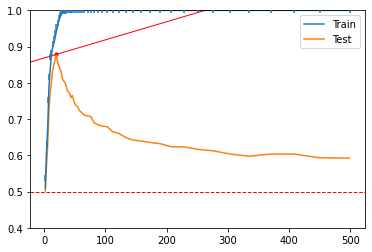

AT (20, 0.8785302416881364, 0.10517580664949086) WITH 52 ITERATIONS IN 156.92819019726343 SECONDS : 32.92079035510797
__main__.SVM_RFE_W_STEP - 00:02:55.547252000


((20, 0.8785302416881364, 0.10517580664949086),
 156.92819019726343,
 (0.10055163082531504, 0.006454749759556446))

In [6]:
SVM_RFE_W_STEP(kernel='poly', degree=6, C=0.6, dstop=20, dstep_p=0.2, sampling_p=0.7, step=5)

poly 0.6 7 1.0


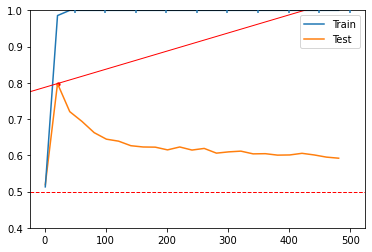

AT (21, 0.7980195243353139, 0.1699843805317489) WITH 10 ITERATIONS IN 8.69671038218907 SECONDS : 0.061179008275992285
__main__.SVM_RFE_W_STEP - 00:00:18.464944800


((21, 0.7980195243353139, 0.1699843805317489),
 8.69671038218907,
 (0.16998438053174897, 0.01795923990267801))

In [32]:
SVM_RFE_W_STEP(kernel='poly', degree=7, C=0.6, dstop=20, dstep_p=0.0001, sampling_p=0.2, step=50)

poly 0.1 1 1.0


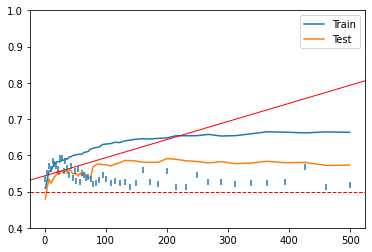

AT (22, 0.5544981334455018, 0.3652014932435986) WITH 52 ITERATIONS IN 20.249493667057582 SECONDS : 0.2441811911440403
__main__.SVM_RFE_W_STEP - 00:00:31.007195700
poly 0.2 1 1.0


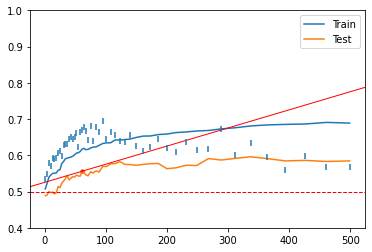

AT (61, 0.5559878717773454, 0.37960970257812365) WITH 52 ITERATIONS IN 20.666028227124894 SECONDS : 0.3727371915873038
__main__.SVM_RFE_W_STEP - 00:00:32.199524900
poly 0.3 1 1.0


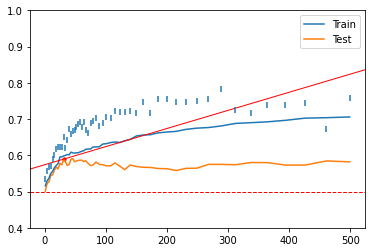

AT (31, 0.5895262632104737, 0.34077898943162105) WITH 52 ITERATIONS IN 21.375565937587194 SECONDS : 0.33403491652946665
__main__.SVM_RFE_W_STEP - 00:00:34.026122900
poly 0.4 1 1.0


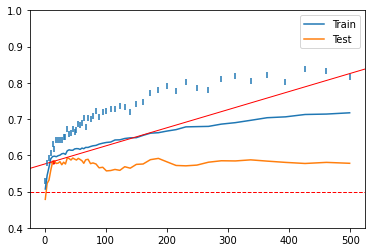

AT (13, 0.5825209877841457, 0.3391832097726834) WITH 52 ITERATIONS IN 19.714717354093278 SECONDS : 0.19471483512294832
__main__.SVM_RFE_W_STEP - 00:00:31.215667100
poly 0.5 1 1.0


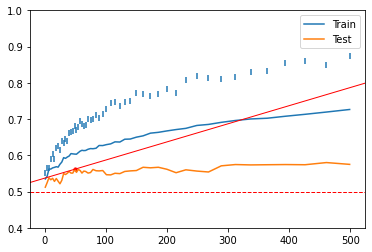

AT (49, 0.5615016562384983, 0.3703986750092014) WITH 52 ITERATIONS IN 19.899009125573293 SECONDS : 0.16195581245402044
__main__.SVM_RFE_W_STEP - 00:00:31.364556100
poly 0.6 1 1.0


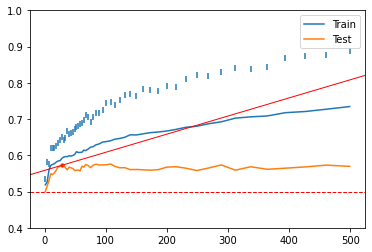

AT (28, 0.5724643777275356, 0.35322849781797155) WITH 52 ITERATIONS IN 19.099572045462473 SECONDS : 0.08243947809474934
__main__.SVM_RFE_W_STEP - 00:00:30.109162600
poly 0.7 1 1.0


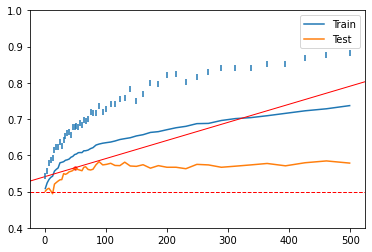

AT (49, 0.5654871444345128, 0.36721028445238985) WITH 52 ITERATIONS IN 19.19300297328404 SECONDS : 0.25562234855025817
__main__.SVM_RFE_W_STEP - 00:00:30.344315100
poly 0.8 1 1.0


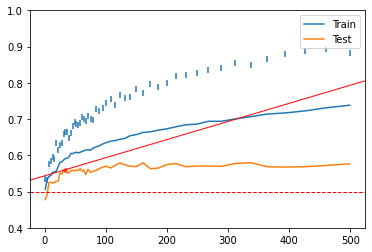

AT (34, 0.5604553341395447, 0.36523573268836423) WITH 52 ITERATIONS IN 19.491862024579728 SECONDS : 0.15156625410167163
__main__.SVM_RFE_W_STEP - 00:00:30.894176500
poly 0.9 1 1.0


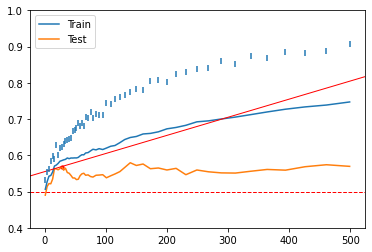

AT (28, 0.5690134426976532, 0.35598924584187747) WITH 52 ITERATIONS IN 19.4907169342041 SECONDS : 0.02811432780613034
__main__.SVM_RFE_W_STEP - 00:00:30.780198700
poly 0.1 2 1.0


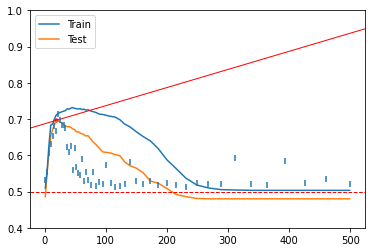

AT (19, 0.69649648597017, 0.25040281122386404) WITH 52 ITERATIONS IN 20.808577503476823 SECONDS : 0.05367812850734398
__main__.SVM_RFE_W_STEP - 00:00:31.628460800
poly 0.2 2 1.0


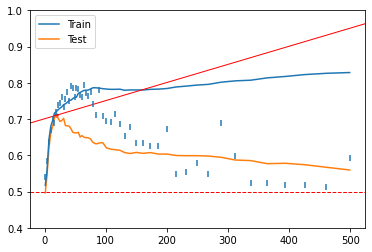

AT (19, 0.7104842525895159, 0.2392125979283873) WITH 52 ITERATIONS IN 20.78748038836888 SECONDS : 0.25112751942897743
__main__.SVM_RFE_W_STEP - 00:00:31.644540300
poly 0.3 2 1.0


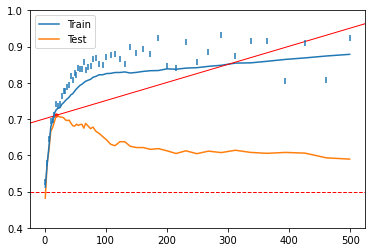

AT (19, 0.7105070368228262, 0.23919437054173903) WITH 52 ITERATIONS IN 20.616999558040074 SECONDS : 0.19877785800337724
__main__.SVM_RFE_W_STEP - 00:00:31.957445400
poly 0.4 2 1.0


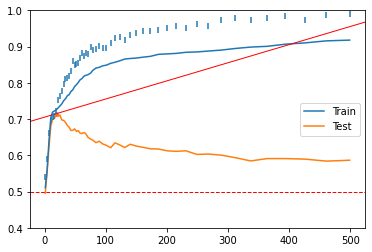

AT (19, 0.7149727465516938, 0.23562180275864492) WITH 52 ITERATIONS IN 21.184570687157766 SECONDS : 0.14015930755307665
__main__.SVM_RFE_W_STEP - 00:00:32.266845600
poly 0.5 2 1.0


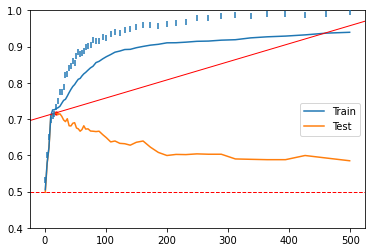

AT (19, 0.7175105596158229, 0.2335915523073417) WITH 52 ITERATIONS IN 20.430145297731674 SECONDS : 0.29583403090073634
__main__.SVM_RFE_W_STEP - 00:00:31.942401400
poly 0.6 2 1.0


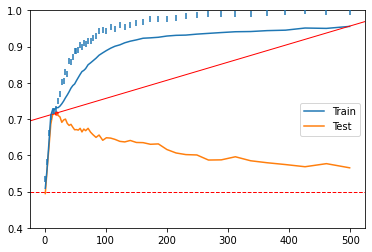

AT (19, 0.7165063007168272, 0.23439495942653826) WITH 52 ITERATIONS IN 20.138145514896937 SECONDS : 0.3485897892253549
__main__.SVM_RFE_W_STEP - 00:00:31.968374900
poly 0.7 2 1.0


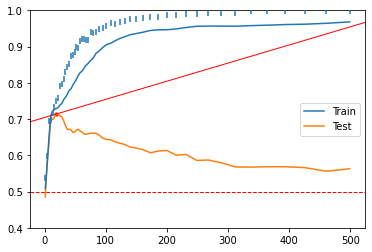

AT (19, 0.7139947771526718, 0.2364041782778626) WITH 52 ITERATIONS IN 20.025721549987793 SECONDS : 0.4948853770521282
__main__.SVM_RFE_W_STEP - 00:00:32.285329200
poly 0.8 2 1.0


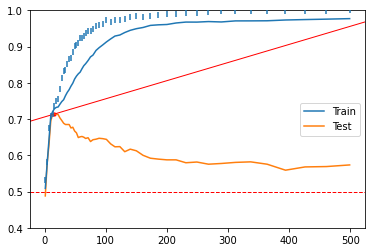

AT (16, 0.7140123034859878, 0.23519015721120978) WITH 52 ITERATIONS IN 19.765715258462087 SECONDS : 0.3041513444111527
__main__.SVM_RFE_W_STEP - 00:00:32.053228100
poly 0.9 2 1.0


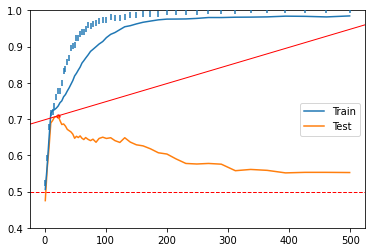

AT (22, 0.7090120405909881, 0.24159036752720953) WITH 52 ITERATIONS IN 19.737296070371354 SECONDS : 0.2582007161414664
__main__.SVM_RFE_W_STEP - 00:00:32.215707900
poly 0.1 3 1.0


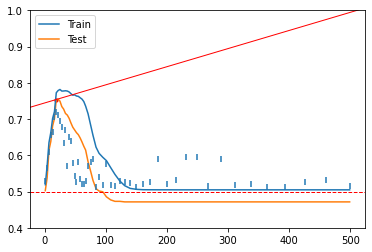

AT (19, 0.7540196645459804, 0.20438426836321572) WITH 52 ITERATIONS IN 20.752138921192714 SECONDS : 0.17143381181328868
__main__.SVM_RFE_W_STEP - 00:00:35.670921300
poly 0.2 3 1.0


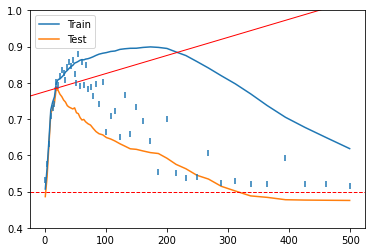

AT (19, 0.7850114797483219, 0.1795908162013425) WITH 52 ITERATIONS IN 20.651570422308787 SECONDS : 0.11273277928455394
__main__.SVM_RFE_W_STEP - 00:00:35.221547300
poly 0.3 3 1.0


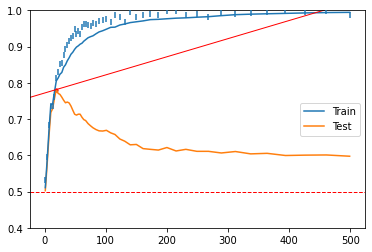

AT (19, 0.7814729130518605, 0.1824216695585116) WITH 52 ITERATIONS IN 20.764855895723617 SECONDS : 0.06751058937727893
__main__.SVM_RFE_W_STEP - 00:00:35.577989600
poly 0.4 3 1.0


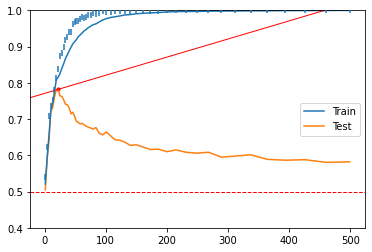

AT (22, 0.7819969504180031, 0.18320243966559754) WITH 52 ITERATIONS IN 20.761709724153793 SECONDS : 0.12724564844879474
__main__.SVM_RFE_W_STEP - 00:00:36.243641700
poly 0.5 3 1.0


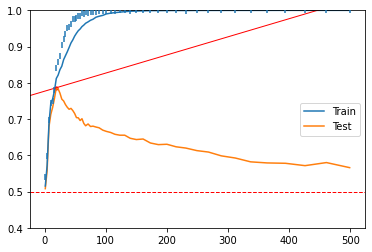

AT (19, 0.7864977128135022, 0.17840182974919822) WITH 52 ITERATIONS IN 21.56042923246111 SECONDS : 0.04789948282370683
__main__.SVM_RFE_W_STEP - 00:00:37.024064000
poly 0.6 3 1.0


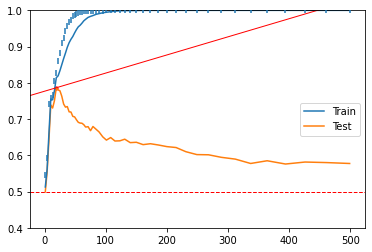

AT (19, 0.786490702280176, 0.1784074381758592) WITH 52 ITERATIONS IN 20.42328401974269 SECONDS : 0.2530550476424103
__main__.SVM_RFE_W_STEP - 00:00:36.619142100
poly 0.7 3 1.0


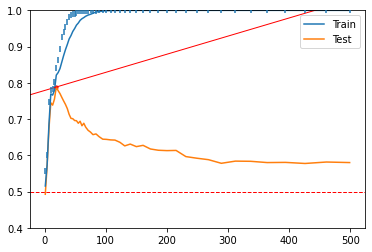

AT (19, 0.7884974674448358, 0.17680202604413134) WITH 52 ITERATIONS IN 20.83042519433158 SECONDS : 0.1866442477402954
__main__.SVM_RFE_W_STEP - 00:00:37.321540500
poly 0.8 3 1.0


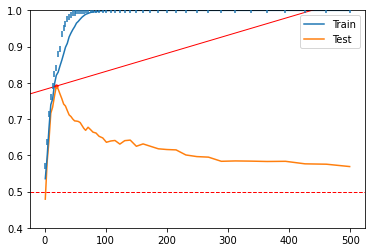

AT (19, 0.7910072383756593, 0.17479420929947254) WITH 52 ITERATIONS IN 20.970000948224747 SECONDS : 0.13736731371470193
__main__.SVM_RFE_W_STEP - 00:00:37.534682300
poly 0.9 3 1.0


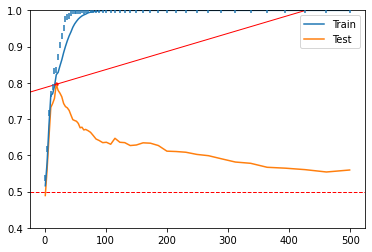

AT (19, 0.7959969854706695, 0.17080241162346438) WITH 52 ITERATIONS IN 20.390854290553502 SECONDS : 0.18719127193366594
__main__.SVM_RFE_W_STEP - 00:00:39.505288500
poly 0.1 4 1.0


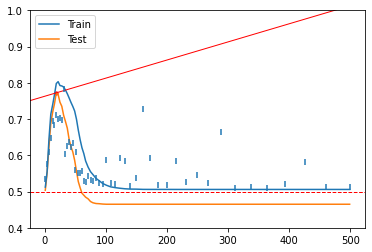

AT (19, 0.7724415934942251, 0.1896467252046199) WITH 52 ITERATIONS IN 24.10756117956979 SECONDS : 0.440068064092311
__main__.SVM_RFE_W_STEP - 00:00:41.179551100
poly 0.2 4 1.0


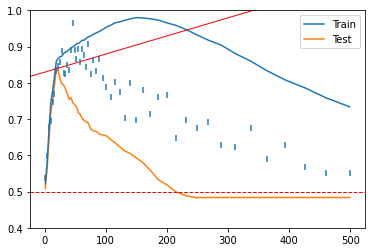

AT (19, 0.8389890810943442, 0.13640873512452462) WITH 52 ITERATIONS IN 24.01471185684204 SECONDS : 0.010780670315365828
__main__.SVM_RFE_W_STEP - 00:00:39.859376800
poly 0.3 4 1.0


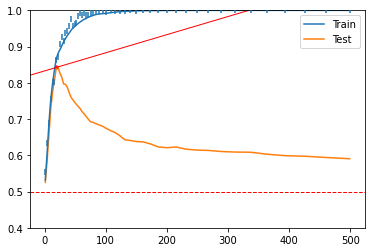

AT (19, 0.8425066161908267, 0.13359470704733867) WITH 52 ITERATIONS IN 22.299713952200754 SECONDS : 0.0962864033446531
__main__.SVM_RFE_W_STEP - 00:00:37.647579800
poly 0.4 4 1.0


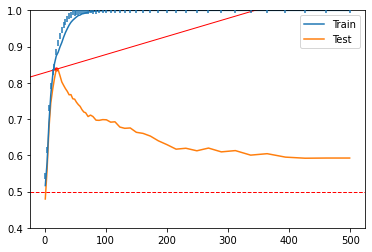

AT (19, 0.8374975901291692, 0.13760192789666462) WITH 52 ITERATIONS IN 21.30642557144165 SECONDS : 0.06441077400792697
__main__.SVM_RFE_W_STEP - 00:00:36.669223100
poly 0.5 4 1.0


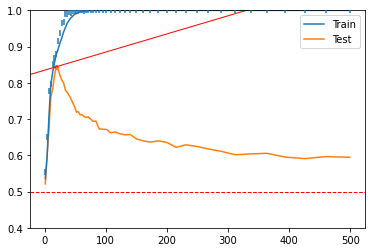

AT (19, 0.844502865555497, 0.1319977075556024) WITH 52 ITERATIONS IN 21.47556928225926 SECONDS : 0.16695133204373228
__main__.SVM_RFE_W_STEP - 00:00:37.178816800
poly 0.6 4 1.0


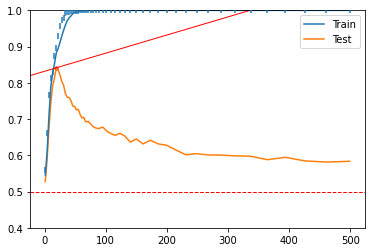

AT (19, 0.8414830783251838, 0.13441353733985298) WITH 52 ITERATIONS IN 21.089713743754796 SECONDS : 0.06827667543919289
__main__.SVM_RFE_W_STEP - 00:00:36.837783000
poly 0.7 4 1.0


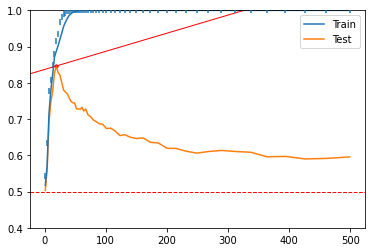

AT (19, 0.8464991149201675, 0.130400708063866) WITH 52 ITERATIONS IN 21.648571184703282 SECONDS : 0.14328930059348158
__main__.SVM_RFE_W_STEP - 00:00:37.753393200
poly 0.8 4 1.0


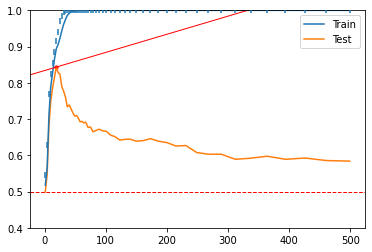

AT (19, 0.8435301540564699, 0.13277587675482408) WITH 52 ITERATIONS IN 21.095855270113265 SECONDS : 0.07859614764576542
__main__.SVM_RFE_W_STEP - 00:00:37.173924200
poly 0.9 4 1.0


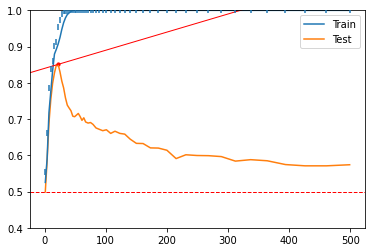

AT (22, 0.8509946194156719, 0.1280043044674625) WITH 52 ITERATIONS IN 21.22500021117074 SECONDS : 0.05538153445318316
__main__.SVM_RFE_W_STEP - 00:00:37.231543500
poly 0.1 5 1.0


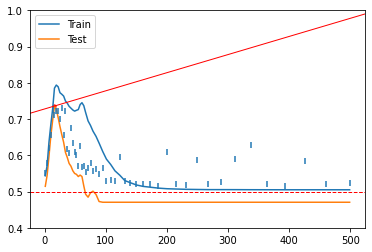

AT (16, 0.736018367597315, 0.217585305922148) WITH 52 ITERATIONS IN 21.586428131375992 SECONDS : 0.18708551634276493
__main__.SVM_RFE_W_STEP - 00:00:37.152403000
poly 0.2 5 1.0


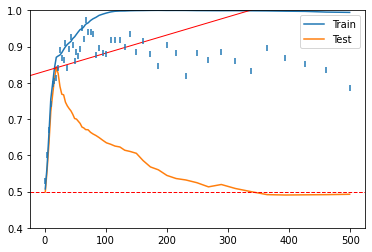

AT (19, 0.8414918414918416, 0.13440652680652668) WITH 52 ITERATIONS IN 21.979457718985422 SECONDS : 0.20322251044993497
__main__.SVM_RFE_W_STEP - 00:00:37.595730200
poly 0.3 5 1.0


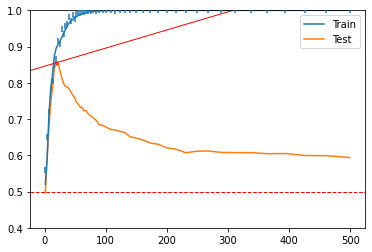

AT (19, 0.8554708449445292, 0.12322332404437665) WITH 52 ITERATIONS IN 21.521851743970597 SECONDS : 0.06796241259130233
__main__.SVM_RFE_W_STEP - 00:00:37.334016500
poly 0.4 5 1.0


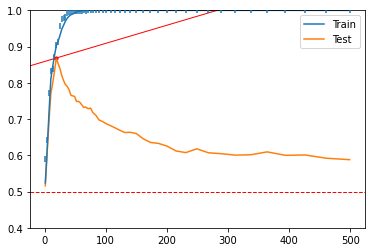

AT (19, 0.8684841474315157, 0.11281268205478745) WITH 52 ITERATIONS IN 22.644140277590072 SECONDS : 0.07838304468302516
__main__.SVM_RFE_W_STEP - 00:00:38.181832200
poly 0.5 5 1.0


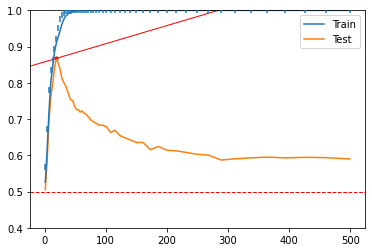

AT (19, 0.8675114359324886, 0.11359085125400914) WITH 52 ITERATIONS IN 21.466568844658987 SECONDS : 0.31827726129688244
__main__.SVM_RFE_W_STEP - 00:00:37.389191600
poly 0.6 5 1.0


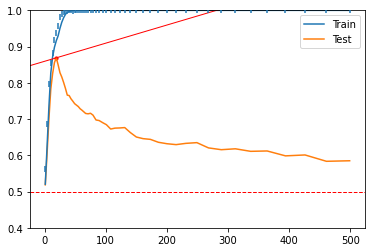

AT (19, 0.8690169479643165, 0.1123864416285468) WITH 52 ITERATIONS IN 21.39114417348589 SECONDS : 0.4247670667286401
__main__.SVM_RFE_W_STEP - 00:00:37.562553200
poly 0.7 5 1.0


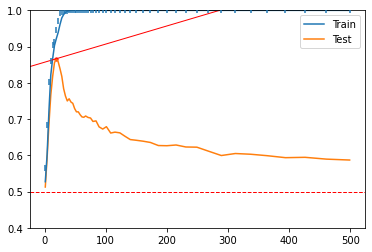

AT (19, 0.8664949086001718, 0.1144040731198626) WITH 52 ITERATIONS IN 21.06656857899257 SECONDS : 0.386170803530562
__main__.SVM_RFE_W_STEP - 00:00:37.275823300
poly 0.8 5 1.0


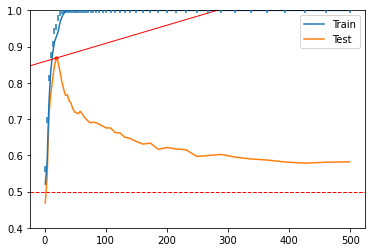

AT (19, 0.8684859000648475, 0.11281127994812201) WITH 52 ITERATIONS IN 21.266144684382848 SECONDS : 0.04683950983855204
__main__.SVM_RFE_W_STEP - 00:00:36.999288100
poly 0.9 5 1.0


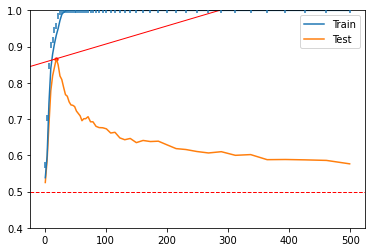

AT (19, 0.8665124349334875, 0.11439005205321) WITH 52 ITERATIONS IN 21.49100034577506 SECONDS : 0.14302844654220076
__main__.SVM_RFE_W_STEP - 00:00:37.379891300
poly 0.1 6 1.0


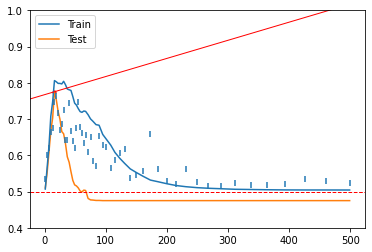

AT (16, 0.7754456070245543, 0.18604351438035652) WITH 52 ITERATIONS IN 21.409288678850448 SECONDS : 0.14833929274338367
__main__.SVM_RFE_W_STEP - 00:00:36.548284900
poly 0.2 6 1.0


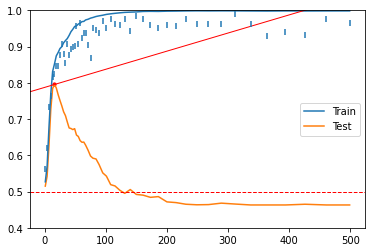

AT (16, 0.7954536691378796, 0.1700370646896963) WITH 52 ITERATIONS IN 21.31656915800912 SECONDS : 0.09873832481017017
__main__.SVM_RFE_W_STEP - 00:00:36.465937600
poly 0.3 6 1.0


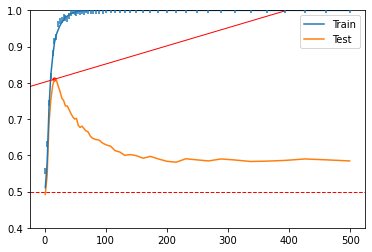

AT (16, 0.8100198047566468, 0.15838415619468255) WITH 52 ITERATIONS IN 21.939721414021083 SECONDS : 0.07154193901186894
__main__.SVM_RFE_W_STEP - 00:00:37.917624900
poly 0.4 6 1.0


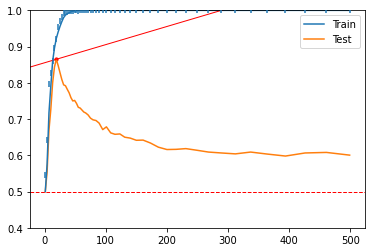

AT (19, 0.864992901835007, 0.11560567853199441) WITH 52 ITERATIONS IN 21.738111564091273 SECONDS : 0.13179702187521658
__main__.SVM_RFE_W_STEP - 00:00:37.964160200
poly 0.5 6 1.0


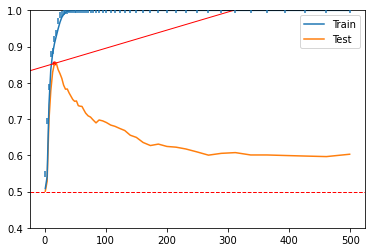

AT (16, 0.853490369279843, 0.1236077045761256) WITH 52 ITERATIONS IN 21.549425670078822 SECONDS : 0.25804462983348125
__main__.SVM_RFE_W_STEP - 00:00:37.503849400
poly 0.6 6 1.0


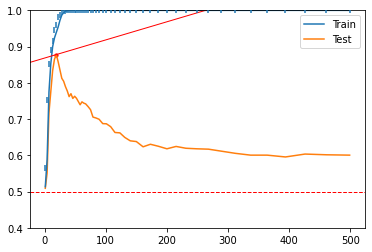

AT (19, 0.8779869253553466, 0.10521045971572271) WITH 52 ITERATIONS IN 21.838243654796056 SECONDS : 0.12424733366917597
__main__.SVM_RFE_W_STEP - 00:00:37.765541100
poly 0.7 6 1.0


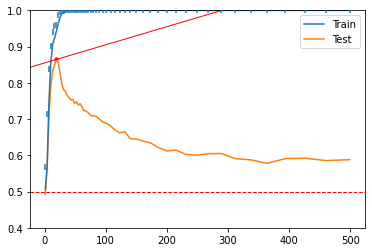

AT (19, 0.8645074224021593, 0.11599406207827258) WITH 52 ITERATIONS IN 21.6115688596453 SECONDS : 0.10709620085376811
__main__.SVM_RFE_W_STEP - 00:00:37.499828400
poly 0.8 6 1.0


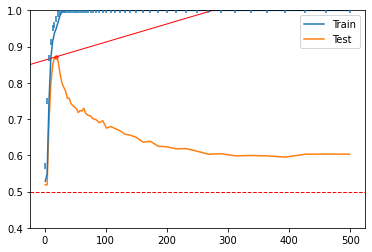

AT (19, 0.8720174562279824, 0.10998603501761406) WITH 52 ITERATIONS IN 21.62728670665196 SECONDS : 0.04321627511846452
__main__.SVM_RFE_W_STEP - 00:00:39.150321800
poly 0.9 6 1.0


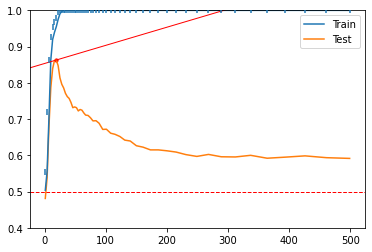

AT (19, 0.8629861366703472, 0.11721109066372226) WITH 52 ITERATIONS IN 22.128708056041173 SECONDS : 0.10294030012423903
__main__.SVM_RFE_W_STEP - 00:00:38.262238900
poly 0.1 7 1.0


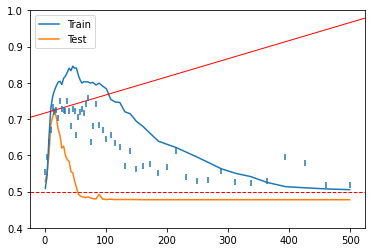

AT (16, 0.7245368666421298, 0.22677050668629617) WITH 52 ITERATIONS IN 21.687002113887242 SECONDS : 0.25924900671500895
__main__.SVM_RFE_W_STEP - 00:00:37.074425000
poly 0.2 7 1.0


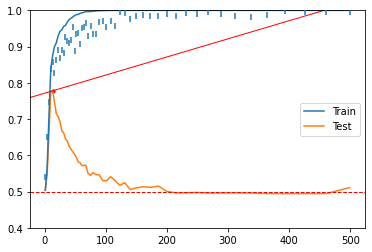

AT (13, 0.7779536253220464, 0.18283709974236292) WITH 52 ITERATIONS IN 21.4432852268219 SECONDS : 0.2543550648583083
__main__.SVM_RFE_W_STEP - 00:00:37.203317800
poly 0.3 7 1.0


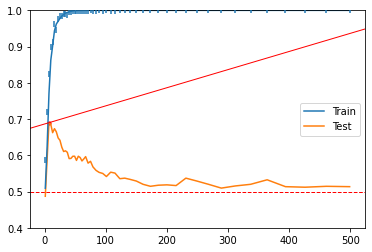

AT (7, 0.6900362795099638, 0.25077097639202894) WITH 52 ITERATIONS IN 21.980855090277537 SECONDS : 0.10095664545189943
__main__.SVM_RFE_W_STEP - 00:00:38.402705300
poly 0.4 7 1.0


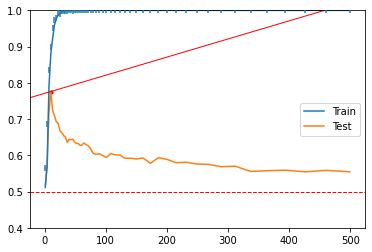

AT (10, 0.7760432549906234, 0.18316539600750126) WITH 52 ITERATIONS IN 21.62314326422555 SECONDS : 0.20765781994442728
__main__.SVM_RFE_W_STEP - 00:00:38.224588400
poly 0.5 7 1.0


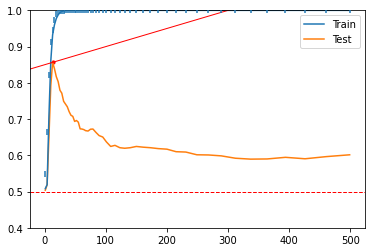

AT (13, 0.8565224249434776, 0.1199820600452179) WITH 52 ITERATIONS IN 21.616567747933523 SECONDS : 0.19275141676809548
__main__.SVM_RFE_W_STEP - 00:00:37.995604500
poly 0.6 7 1.0


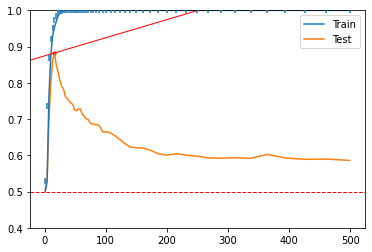

AT (16, 0.8824806772175194, 0.10041545822598445) WITH 52 ITERATIONS IN 21.821281944002425 SECONDS : 0.13668636067012468
__main__.SVM_RFE_W_STEP - 00:00:37.526250500
poly 0.7 7 1.0


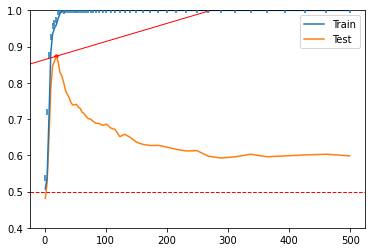

AT (19, 0.8734984313931681, 0.10880125488546555) WITH 52 ITERATIONS IN 21.796282972608292 SECONDS : 0.4308959842060246
__main__.SVM_RFE_W_STEP - 00:00:38.373223700
poly 0.8 7 1.0


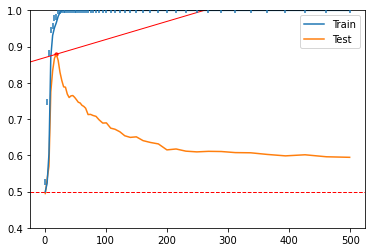

AT (19, 0.878991184254342, 0.10440705259652643) WITH 52 ITERATIONS IN 21.338000433785574 SECONDS : 0.11905295030661198
__main__.SVM_RFE_W_STEP - 00:00:37.678314900
poly 0.9 7 1.0


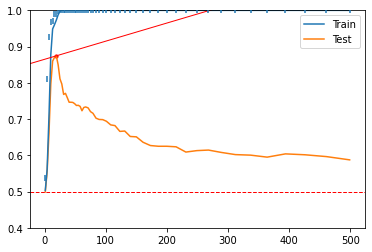

AT (19, 0.8745184639921482, 0.10798522880628147) WITH 52 ITERATIONS IN 21.3941707611084 SECONDS : 0.34865914129673975
__main__.SVM_RFE_W_STEP - 00:00:37.241376300
poly 0.1 8 1.0


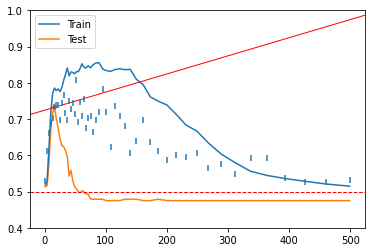

AT (16, 0.7325569167674432, 0.22035446658604546) WITH 52 ITERATIONS IN 21.646429334368026 SECONDS : 0.1272912519388558
__main__.SVM_RFE_W_STEP - 00:00:36.850032900
poly 0.2 8 1.0


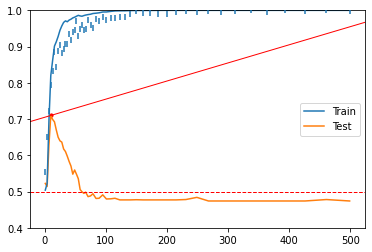

AT (10, 0.7099742362900257, 0.2360206109679795) WITH 52 ITERATIONS IN 22.252573251724243 SECONDS : 0.0752993612754673
__main__.SVM_RFE_W_STEP - 00:00:38.223357600
poly 0.3 8 1.0


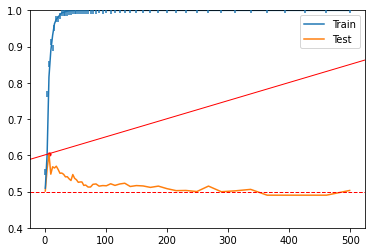

AT (7, 0.6044481833955517, 0.3192414532835587) WITH 52 ITERATIONS IN 22.16200007711138 SECONDS : 0.060373025153481016
__main__.SVM_RFE_W_STEP - 00:00:38.402444000
poly 0.4 8 1.0


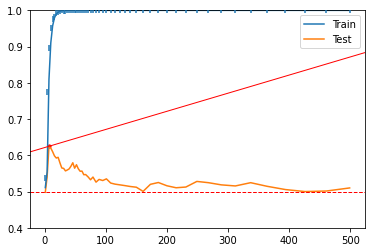

AT (7, 0.6249522407417144, 0.30283820740662853) WITH 52 ITERATIONS IN 21.83814242907933 SECONDS : 0.13141381528538315
__main__.SVM_RFE_W_STEP - 00:00:38.210657600
poly 0.5 8 1.0


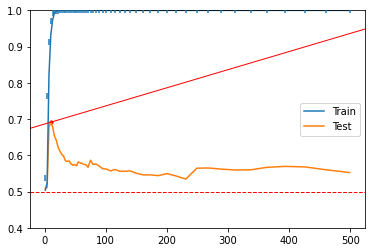

AT (10, 0.691401580875265, 0.250878735299788) WITH 52 ITERATIONS IN 21.87456907544817 SECONDS : 0.05090134186390543
__main__.SVM_RFE_W_STEP - 00:00:37.814592900
poly 0.6 8 1.0


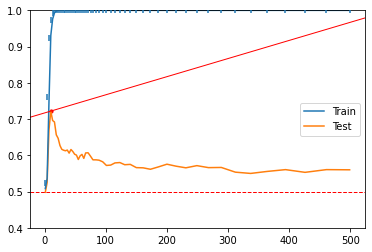

AT (10, 0.7220253430779746, 0.2263797255376203) WITH 52 ITERATIONS IN 22.03128640992301 SECONDS : 0.21430385091299536
__main__.SVM_RFE_W_STEP - 00:00:38.431315600
poly 0.7 8 1.0


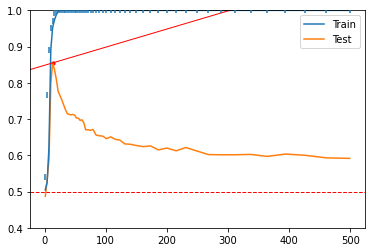

AT (13, 0.8550151602783183, 0.1211878717773454) WITH 52 ITERATIONS IN 22.345429352351598 SECONDS : 0.1654365587322626
__main__.SVM_RFE_W_STEP - 00:00:38.522525900
poly 0.8 8 1.0


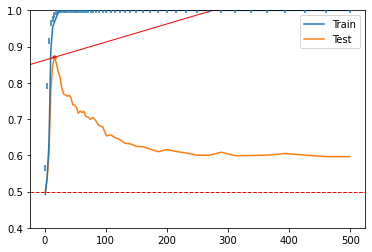

AT (16, 0.8705242126294757, 0.10998062989641948) WITH 52 ITERATIONS IN 21.737859385354177 SECONDS : 0.11454376965783626
__main__.SVM_RFE_W_STEP - 00:00:37.752153300
poly 0.9 8 1.0


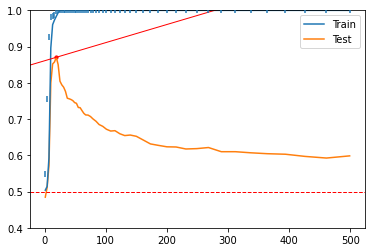

AT (19, 0.87050668629616, 0.11119465096307199) WITH 52 ITERATIONS IN 22.169713973999023 SECONDS : 0.26595594403480455
__main__.SVM_RFE_W_STEP - 00:00:38.337314400
poly 0.1 9 1.0


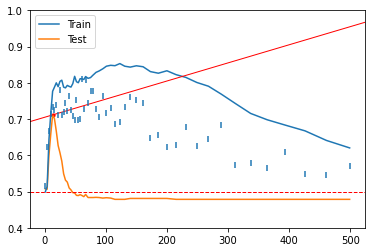

AT (13, 0.7115375852217957, 0.23596993182256348) WITH 52 ITERATIONS IN 20.1624276978629 SECONDS : 0.030804181092101
__main__.SVM_RFE_W_STEP - 00:00:34.609468300
poly 0.2 9 1.0


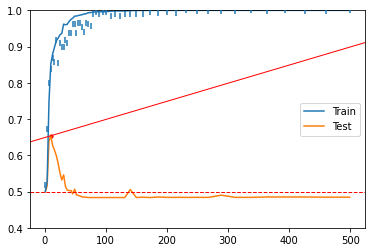

AT (10, 0.6539740960793592, 0.2808207231365127) WITH 52 ITERATIONS IN 20.150001287460327 SECONDS : 0.11649758131799055
__main__.SVM_RFE_W_STEP - 00:00:36.202593900
poly 0.3 9 1.0


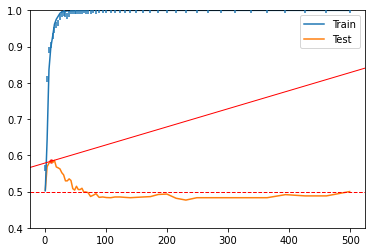

AT (10, 0.583505967716494, 0.33719522582680483) WITH 52 ITERATIONS IN 21.79228448867798 SECONDS : 0.1642509247904432
__main__.SVM_RFE_W_STEP - 00:00:38.319221400
poly 0.4 9 1.0


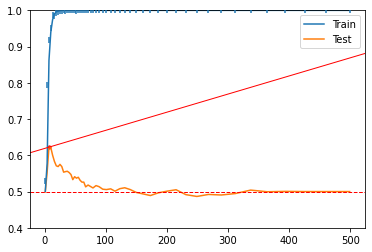

AT (7, 0.6225301014774699, 0.3047759188180241) WITH 52 ITERATIONS IN 22.001144851957047 SECONDS : 0.08779990165874793
__main__.SVM_RFE_W_STEP - 00:00:38.357246200
poly 0.5 9 1.0


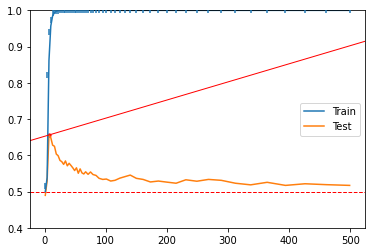

AT (7, 0.6560895245105771, 0.27792838039153833) WITH 52 ITERATIONS IN 22.038390398025513 SECONDS : 0.16362566918764646
__main__.SVM_RFE_W_STEP - 00:00:38.478736300
poly 0.6 9 1.0


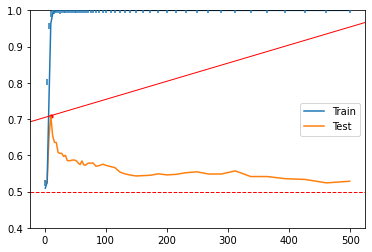

AT (10, 0.7093906093906094, 0.2364875124875125) WITH 52 ITERATIONS IN 22.244141783033097 SECONDS : 0.33093753925448494
__main__.SVM_RFE_W_STEP - 00:00:39.246615200
poly 0.7 9 1.0


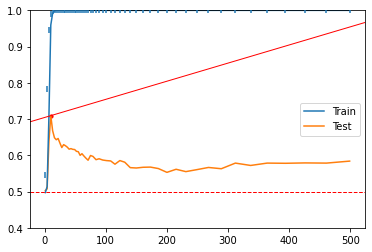

AT (10, 0.7094817463238516, 0.2364146029409187) WITH 52 ITERATIONS IN 22.05771051134382 SECONDS : 0.15221938913058072
__main__.SVM_RFE_W_STEP - 00:00:38.383077700
poly 0.8 9 1.0


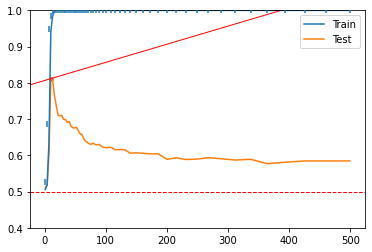

AT (10, 0.8115691326217641, 0.15474469390258871) WITH 52 ITERATIONS IN 21.923856156212942 SECONDS : 0.2253129664879884
__main__.SVM_RFE_W_STEP - 00:00:38.281228300
poly 0.9 9 1.0


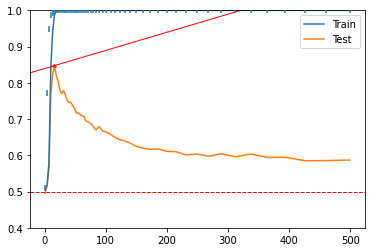

AT (16, 0.8474946106525054, 0.12840431147799566) WITH 52 ITERATIONS IN 23.063143355505808 SECONDS : 0.26976557979933624
__main__.SVM_RFE_W_STEP - 00:00:39.032274700


In [13]:
model_selection = {}
for d in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    for C in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        model_selection[C, d] = SVM_RFE_W_STEP(kernel='poly', degree=d, C=C,  dstop=20, dstep_p=0.08, sampling_p=0.2, step=3)

In [19]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {7: 1, 8: 2, 9: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "  {:>3s} & {:.2f}\\% & {:.3f} $\\pm$ {:.3f}".format(str(v[0][0]), 100 * v[0][1], v[2][0], v[2][1])

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} &    16 & 72.45\% & 0.189 $\pm$ 0.012 &    16 & 73.26\% & 0.190 $\pm$ 0.020 &    13 & 71.15\% & 0.223 $\pm$ 0.024\\
\textbf{0.2} &    13 & 77.80\% & 0.174 $\pm$ 0.027 &    10 & 71.00\% & 0.206 $\pm$ 0.024 &    10 & 65.40\% & 0.258 $\pm$ 0.027\\
\textbf{0.3} &     7 & 69.00\% & 0.219 $\pm$ 0.026 &     7 & 60.44\% & 0.280 $\pm$ 0.023 &    10 & 58.35\% & 0.318 $\pm$ 0.010\\
\textbf{0.4} &    10 & 77.60\% & 0.176 $\pm$ 0.023 &     7 & 62.50\% & 0.276 $\pm$ 0.029 &     7 & 62.25\% & 0.284 $\pm$ 0.022\\
\textbf{0.5} &    13 & 85.65\% & 0.117 $\pm$ 0.012 &    10 & 69.14\% & 0.212 $\pm$ 0.029 &     7 & 65.61\% & 0.258 $\pm$ 0.031\\
\textbf{0.6} &    16 & 88.25\% & 0.098 $\pm$ 0.004 &    10 & 72.20\% & 0.195 $\pm$ 0.025 &    10 & 70.94\% & 0.214 $\pm$ 0.030\\
\textbf{0.7} &    19 & 87.35\% & 0.105 $\pm$ 0.009 &    13 & 85.50\% & 0.116 $\pm$ 0.008 &    10 & 70.95\% & 0.215 $\pm$ 0.037\\
\textbf{0.8} &    19 & 87.90\% & 0.104 $\pm$ 0.005 &    16 & 87.05\% & 0.102 $\pm$ 0.005 &    10 

In [15]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.1f}".format(C) + '}', '', '', '', '', '', '', '', '', '']

for C, d in model_selection:
    col = {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>2s}".format(math.floor(v[1]/60.0), str(int(v[1] % 60)), str(int((v[1] % 1) * 100)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.1} & 0:20.24 & 0:20.80 & 0:20.75 & 0:24.10 & 0:21.58 & 0:21.40 & 0:21.68 & 0:21.64 & 0:20.16\\
\textbf{0.2} & 0:20.66 & 0:20.78 & 0:20.65 & 0:24.01 & 0:21.97 & 0:21.31 & 0:21.44 & 0:22.25 & 0:20.15\\
\textbf{0.3} & 0:21.37 & 0:20.61 & 0:20.76 & 0:22.29 & 0:21.52 & 0:21.93 & 0:21.98 & 0:22.16 & 0:21.79\\
\textbf{0.4} & 0:19.71 & 0:21.18 & 0:20.76 & 0:21.30 & 0:22.64 & 0:21.73 & 0:21.62 & 0:21.83 & 0:22.00\\
\textbf{0.5} & 0:19.89 & 0:20.43 & 0:21.56 & 0:21.47 & 0:21.46 & 0:21.54 & 0:21.61 & 0:21.87 & 0:22.03\\
\textbf{0.6} & 0:19.09 & 0:20.13 & 0:20.42 & 0:21.08 & 0:21.39 & 0:21.83 & 0:21.82 & 0:22.03 & 0:22.24\\
\textbf{0.7} & 0:19.19 & 0:20.02 & 0:20.83 & 0:21.64 & 0:21.06 & 0:21.61 & 0:21.79 & 0:22.34 & 0:22.05\\
\textbf{0.8} & 0:19.49 & 0:19.76 & 0:20.97 & 0:21.09 & 0:21.26 & 0:21.62 & 0:21.33 & 0:21.73 & 0:21.92\\
\textbf{0.9} & 0:19.49 & 0:19.73 & 0:20.39 & 0:21.22 & 0:21.49 & 0:22.12 & 0:21.39 & 0:22.16 & 0:23.06\\


In [12]:
with open('dump2.pickle', 'wb') as filehandler:
    pickle.dump(model_selection, filehandler)